
    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



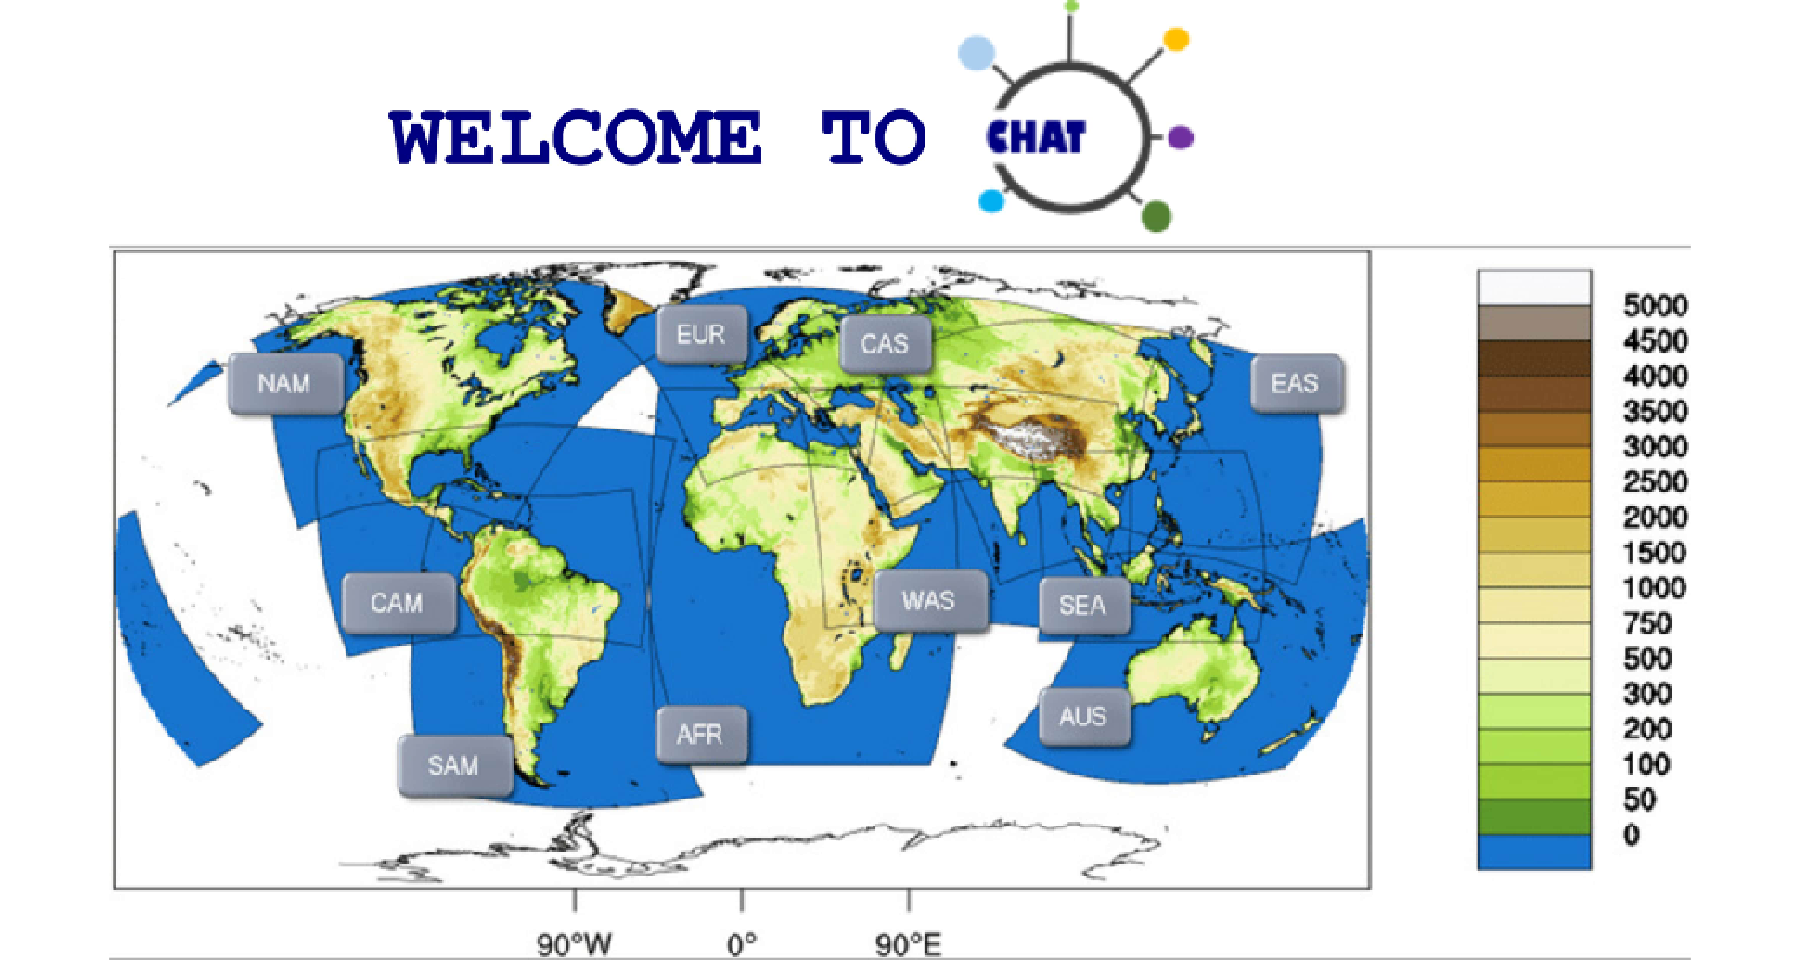

In [3]:
# Sourcing packages and intermediate funnctions
source("../../../../functions/packages_CORE.R")
source("../../../../functions/Hub_CORDEX_CORE3.R")


# CHAT is maid of 6 core functions

## Load data function 
This function load the all CORDEX-CORE models for a certain country or region of interest. By dafault, the whole year is selected. Season selection is performed in the plotting functions

In [ ]:
load_data <-
  function (country,
            domain,
            variable,
            overwrite_security = FALSE,
            xlim = NULL,
            ylim = NULL,
            years = 2010:2099) {
    options(warn = -1)
    
    domain = match.arg(domain,
                       choices = c("AFR-22", "EAS-22", "SAM-22", "AUS-22", "CAS-22", "WAS-22"))
    variable = match.arg(variable,
                         choices = c("pr", "tasmax", "tas", "tasmin", "sfcWind"))
    
    if (!is.null(country) & !is.null(xlim)) {
      stop("Either select a country or a region of interest")
    } else {
      country_shp = if (!is.null(country))
        getData("GADM", country = country, level = 1)
      else
        as(raster::extent(min(xlim), max(xlim), min(ylim), max(ylim)), "SpatialPolygons")
      proj4string(country_shp) = "+proj=longlat +datum=WGS84 +no_defs"
      xlim <-
        c(round(country_shp@bbox[1, 1] - 1),
          round(country_shp@bbox[1, 2] + 1))  # longitude boundaries for the region of interest
      ylim <-
        c(round(country_shp@bbox[2, 1] - 1),
          # latitude boundaries for the region of interest
          round(country_shp@bbox[2, 2] + 1))
    }
    
    range.x <- max(xlim) - min(xlim)
    range.y <-  max(ylim) - min(ylim)
    
    options(warn = 1)
    
    if (range.x > 17 & range.y > 17) {
      core = 1
    } else if (range.x > 18 & range.y > 18) {
      stop("The selecetd region is too big")
    } else {
      if (domain == "CAS-22" | domain == "EAS-22") {
        core = 9
        message(
          Sys.time(),
          paste(
            " Loading the required 3 GCM-RCM climate models, namely MOHC-HadGEM2-ES, MPI-M-MPI-ESM-LR, NCC-NorESM1-M
downscaled with RCMs REMO2015.
The process is currently parallelized using",
            core,
            "cores. 
     This function loads automatically 2 RCPs and the historical simulation run alongside W5E5 dataset."
          )
          
        )
        
        warning(
          "Only 3 CORDEX-CORE models were developed for CAS-22. For EAS-22 only 3 CORDEX-CORE models are loaded",
          call. = FALSE
        )
        
      } else {
        core = 18
        message(
          Sys.time(),
          paste(
            " Loading the required 6 GCM-RCM climate models, namely MOHC-HadGEM2-ES, MPI-M-MPI-ESM-LR, NCC-NorESM1-M
downscaled with RCMs REMO2015 and RegCM4-4.
The process is currently parallelized using",
            core,
            "cores. 
This function loads automatically 2 RCPs and the historical simulation run alongside W5E5 dataset."
          )
          
        )
        
      }
    }
    
    start <-
      paste0(
        "/home/jovyan/shared/data/CORDEX/ncml/interp/from_ESGF//CORDEX//output//",
        domain,
        "//"
      )
    run <- c("GERICS/", ifelse(domain=="WAS-22", "ORNL/","ICTP/"))
    GCMs <-
      c("MOHC-HadGEM2-ES/", "MPI-M-MPI-ESM-LR/", "NCC-NorESM1-M/")
    time_frame <- c("historical/", "rcp26/", "rcp85/")
    file_end <-
      c("GERICS-REMO2015//v1//day//", "ICTP-RegCM4-7//v0/day//")
    
    
    # building the dataset
    
    
    
    files <- paste0(start, run) %>%
      map(., ~ paste0(.x, GCMs) %>%
            map(., ~ paste0(.x, time_frame) %>%
                  map(., ~ paste0(.x, file_end)))) %>%
      unlist() %>%
      str_replace(
        .,
        "MPI-M-MPI-ESM-LR/",
        ifelse(
          str_detect(., "(ICTP)|(ORNL)"),
          "MPI-M-MPI-ESM-MR/",
          "MPI-M-MPI-ESM-LR/"
        )
      ) %>%
      list.files(., full.names = TRUE)
    
    plan(multisession, workers = core)
    
    df1 <-
      tibble(
        path = unlist(files),
        RCP = str_extract(path, "rcp\\d+"),
        simulation = str_extract(path, "GERICS")
      ) %>%
      mutate(
        RCP = ifelse(is.na(RCP), "historical", RCP),
        simulation = ifelse(is.na(simulation), "ICTP", simulation)
      ) %>%
      {
        if (range.x > 17 & range.y > 17 & !overwrite_security) {
          message(
            "Loading 3 models only (RCM RegCM4). The country is large. This process can take 30 minutes. If you want to load 6 models,
        you might be able to do so if you run your analysis on weekends, when the Hub is not used. In this case, set overwrite_security as TRUE"
          )
          filter(., simulation == "GERICS")
        } else if (range.x > 17 &
                   range.y > 17 & overwrite_security)  {
          message(
            "The country is big and dafult would only load 3 models. Nontheless, overwrite_security was set as TRUE so
       6 models are being loaded. The process could fail or take 1 hour"
          )
          .
        }
        else   {
          .
        }
      } %>%
      mutate(
        climate_data = future_map(path,   function(x)  {
          if (str_detect(x, "historical"))
            suppressMessages(
              loadGridData(
                dataset = x,
                var = variable,
                years = 1976:2005,
                lonLim = xlim,
                latLim = ylim,
                season = 1:12
              )
            )
          else
            suppressMessages(
              loadGridData(
                dataset = x,
                var = variable,
                years = years,
                lonLim = xlim,
                latLim = ylim,
                season = 1:12
              )
            )
        }),
        climate_data = mclapply(climate_data, function(x) {
          if (str_detect(variable, "pr")) {
            gridArithmetics(x, 86400, operator = "*")
          } else if (str_detect(variable, "tas")) {
            gridArithmetics(x, 273.15, operator = "-")
          } else {
            x
          }
          
        }, mc.cores = core)
      )
    
    message(paste(Sys.time(), "Done"))
    
    message(paste(Sys.time(),
                  "Aggregating members"))
    
    df2 <- df1 %>%
      group_by(RCP) %>%
      summarise(models = list(climate_data)) %>%
      mutate(models_mbrs = lapply(models, function(x)
        common_dates(x))) %>%
      dplyr::select(-models) %>%
      mutate(obs = list(suppressMessages(
        loadGridData(
          "/home/jovyan/shared/data/observations/W5E5/v1.0/w5e5_v1.0.ncml",
          var = variable,
          years = 1980:2005,
          lonLim = xlim,
          latLim = ylim,
          season = 1:12
        )
      )))
                                  
    models <- df1 %>%
      group_by(RCP) %>%
      summarise(path = list(path)) %>%
      select(path)
    
    message(paste(Sys.time(), "Done"))
    rm(df1)
    gc()
    return(list(df2, country_shp, models, "C4R.dataframe"))
    
  } # end of function




## Climate change signal function
Function to visualize css

In [ ]:
climate_change_signal <-
  function(data,
           lowert = NULL,
           uppert = NULL,
           legend.range_mean = NULL,
           legend.range_sd = NULL,
           save,
           plot_name,
           season,
           int_month = NULL,
           palette = NULL,
           prov.country = NULL,
           consecutive = FALSE,
           duration = "max")  {
    # checking inputs requirement
    if (data[[4]] != "C4R.dataframe")
      stop("The input data does not seem to be the output of the loading function")
    stopifnot(is.logical(consecutive))
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    if (!is.null(lowert) &
        !is.null(uppert))
      stop("select only one threshold")
    if (consecutive &
        (is.null(uppert)) &
        is.null(lowert))
      stop("Specify a threshold for which you want to calculate consecutive days")
    stopifnot(duration == "max" | duration == "total")
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    
    
    # retrieving infromation
    data_list <- data[[1]]
    # to check whether the country is big
    mod.numb <- dim(data[[1]]$models_mbrs[[1]]$Data) [1]
    # shape file of the country of interest
    country_shp <- data[[2]]
    var <- data_list$models_mbrs[[1]]$Variable$varName
    
    # messages
    if (is.null(uppert) & is.null(lowert)) {
      mes = paste0(
        "Climate change signal calculated based on ",
        ifelse(var == "pr", "total ", "mean "),
        var
      )
    }
    if ((!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0(
        var,
        ". Climate change signal in terms of number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        )
      )
    }
    if ((!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Climate change signal in terms of total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    
    if ((!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        var,
        ". Climate change signal in terms of maximum number of consecutive days ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    
    
    if (!is.null(season)) {
      season = list(season)
    } else if (int_month == 6) {
      season = list(c(1:6), c(7:12))
    } else if (int_month == 3)  {
      season = list(c(1:3), c(4:6), c(7:9), c(10:12))
    } else {
      stop("int_month must be either 6 or 3")
    }
    
    plots <- mclapply(season, function(int) {
      data_list <-  data_list %>%
        mutate_at(c("models_mbrs", "obs"), ~ map(., ~ subsetGrid(., season =
                                                                   int)))
      message(Sys.time(), " ccs, season ", glue_collapse(int, "-"), ". ", mes)
      data_list.aggr <- data_list  %>%
        select(-obs) %>% # computing annual aggregation. if threshold is specified, first apply threshold
        mutate(
          models_agg_y = mclapply(models_mbrs, function(x)
            aggregateGrid(x,
                          aggr.y =
                            
                            if (var == "pr" &
                                !consecutive &
                                (is.null(uppert) & is.null(lowert))) {
                              list(FUN = "sum")
                            } else if (var != "pr" &
                                       !consecutive &
                                       (is.null(lowert) & is.null(uppert))) {
                              list(FUN = "mean")
                            } else if (consecutive) {
                              list(
                                FUN = find_max_consec_dry,
                                duration = duration,
                                lowert = lowert,
                                uppert = uppert
                              )
                            } else if (!consecutive) {
                              list(FUN = thrs,
                                   uppert = uppert,
                                   lowert = lowert)
                            }), mc.cores = 3),
          models_agg_tot = map(models_agg_y, function(x)  {
            # divide the data in 30 years time frame for projections
            if (!any(str_detect(x$Dates$start, "1980"))) {
              yrs <- list(2010:2039, 2040:2069, 2070:2099)
              map(yrs, ~ subsetGrid(x, years = .x))
            } else
              x
          })
        )
      
      
      data_list.css <- data_list.aggr %>%
        filter(RCP != "historical") %>% # calculate climate change signal by subtracting historical data
        mutate(
          ccs = map(models_agg_tot, ~ map(.x, function(y)
            gridArithmetics(y, data_list.aggr$models_agg_tot[[1]], operator = "-"))),
          css_mean_mbrs = map(ccs, ~ map(.x, function(y) {
            # Average the 30 years data
            arry_mean <-
              apply(y$Data, c(1, 3, 4), mean, na.rm = TRUE)
            y$Data <- arry_mean
            return(y)
          })),
          css_mean = map(css_mean_mbrs, ~ map(.x, function(y) {
            arry_mean <-
              apply(y$Data, c(2, 3), mean, na.rm = TRUE) # calculate the mean of the css
            y$Data <- arry_mean
            rs <- make_raster(y)
            return(rs)
          })),
          css_sd = map(css_mean_mbrs, ~ map(.x, function(y) {
            arry_sd <- apply(y$Data, c(2, 3), sd) # calculate sd of the css
            y$Data <- arry_sd
            rs <- make_raster(y)
            return(rs)
          })),
          css_sign = map(css_mean_mbrs, ~ map(.x, function(y) {
            arry_sign <-
              agreement(y$Data, 0.6) # calculate proportion of model agreement, 60% threshold
            y$Data <- arry_sign
            rs <- make_raster(y)
            return(rs)
          }))
        ) %>%
        select(-css_mean_mbrs) %>%
        transmute_at(c("css_mean", "css_sd", "css_sign"), ~ map(., stack))
      
      # combining RCPs and cropping
      rs_tot <-
        list(
          stack(data_list.css$css_mean),
          stack(data_list.css$css_sd),
          stack(data_list.css$css_sign)
        )
      
      # crop raster based on country shape file
      rs_tot <- rs_tot %>%
        map(., function(x)
          crop(x, country_shp, snap = "out") %>%
            mask(., country_shp))
      
      for (i in 1:3)  {
        names(rs_tot[[i]]) <-
          c(paste0("RCP2.6_", names(rs_tot[[i]])[1:3]), paste0("RCP8.5_", names(rs_tot[[i]])[4:6]))
      }
      names(rs_tot) <- c("css_mean", "css_sd", "css_sign")
      
      
      # for legends
      
      num.range_sd <-
        if (is.null(legend.range_sd))
          c(range(raster::values(rs_tot$css_sd), na.rm = TRUE))
      else
        legend.range_sd
      
      num.range_mean <-
        if (is.null(legend.range_mean))
          c(range(raster::values(rs_tot$css_mean), na.rm = TRUE))
      else
        legend.range_mean
      
      colors = rev(c("#CCFF00", "yellow", "orange", "red", "brown", "black"))
      # to visualize plots
      options(warn = -1)
      # legends. the legend for css_sign is fixed
      col <-
        if (var == "pr" & !is.null(lowert))
          rev(colors)
      else
        colors
      
      
      if (isFALSE(save))  {
        grass <-
          raster("/home/jovyan/FAO_climate risks team/grass_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crops <-
          raster("/home/jovyan/FAO_climate risks team/crops_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crs(grass) <- "EPSG:4326"
        crs(crops) <- "EPSG:4326"
        
        cover.pal <- colorNumeric("BuGn", c(0, 100),
                                  na.color = "transparent")
        
        
        rs_tot_lg <-
          list(
            css_mean = colorNumeric(if (!is.null(palette))
              palette
              else
                col,
              num.range_mean,
              na.color = "transparent"),
            css_sd = colorNumeric(brewer.pal(7, "PuRd"),
                                  num.range_sd,
                                  na.color = "transparent")
          )
        # base map
        base_map <-  leaflet(country_shp) %>%
          addPolylines(color = "black", weight = 2) %>% #,fillColor= topo.colors(10, alpha = NULL))%>%
          addProviderTiles(providers$OpenStreetMap, group = "base map") %>%
          addProviderTiles(providers$Esri.WorldImagery, group = "Earth map") %>%
          addMiniMap() %>%
          addScaleBar(position = "bottomleft")
        
        options(warn = -1)
        
        # list containing all plots
        plot_list <- lapply(1:6, function(x)
          
          if (x == 1)
            base_map %>%
            addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
            addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
            addRasterImage(rs_tot[[1]][[x]], colors = rs_tot_lg[[1]], group = "css_mean") %>%
            addRasterImage(rs_tot[[2]][[x]], colors = rs_tot_lg[[2]],  group = "css_sd") %>%
            addCircleMarkers(
              data = as.data.frame(rs_tot[[3]][[x]], xy = TRUE) %>% filter(.[[3]] == 1),
              ~ x,
              ~ y,
              color = "black",
              radius = 2
            ) %>%
            addLegend_decreasing(
              pal = rs_tot_lg[[1]],
              values = num.range_mean,
              position = "topleft",
              group = "css_mean",
              opacity = 1,
              decreasing = TRUE
            ) %>%
            addLegend_decreasing(
              pal = rs_tot_lg[[2]],
              values = num.range_sd,
              position = "topleft",
              group = "css_sd",
              opacity = 1,
              decreasing = TRUE
            ) %>%
            addLegend_decreasing(
              pal = cover.pal,
              values = c(0, 100),
              position = "topleft",
              group = c("grass.cover", "crops.cover"),
              opacity = 1,
              decreasing = TRUE
            )  %>%
            addLayersControl(
              baseGroups = c("base map", "Earth map"),
              overlayGroups = c("grass.cover", "crops.cover","css_mean", "css_sd" )
            )
          else
            
            base_map %>%
            addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
            addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
            addRasterImage(rs_tot[[1]][[x]], colors = rs_tot_lg[[1]], group = "css_mean") %>%
            addRasterImage(rs_tot[[2]][[x]], colors = rs_tot_lg[[2]],  group = "css_sd") %>%
            addCircleMarkers(
              data = as.data.frame(rs_tot[[3]][[x]], xy = TRUE) %>% filter(.[[3]] == 1),
              ~ x,
              ~ y,
              color = "black",
              radius = 2
            ) %>%
            addLayersControl(
              baseGroups = c("base map", "Earth map"),
              overlayGroups = c("grass.cover", "crops.cover","css_mean", "css_sd" )
            ))
        
        
        return(
          sync(
            plot_list[[1]],
            plot_list[[2]],
            plot_list[[3]],
            plot_list[[4]],
            plot_list[[5]],
            plot_list[[6]],
            ncol = 3,
            sync = list(c(1, 2, 3), c(4, 5, 6)),
            sync.cursor = FALSE
          )
        )
      } else {
        # to save plots
        
        
        rs_df <-
          map(
            rs_tot,
            ~ as.data.frame(.x, xy = TRUE, na.rm = TRUE) %>%
              pivot_longer(
                cols = 3:ncol(.),
                values_to = "value",
                names_to = "long_name"
              ) %>%
              mutate(
                scenario = str_extract(long_name, "RCP\\d.\\d"),
                time_frame = str_extract(long_name, "2\\d+_\\d+")
              ) %>%
              mutate(time_frame = str_replace(time_frame, "_", "-"))
          )
        
        
        countries <-
          ne_countries(scale = "medium", returnclass = "sf")
        
        provinces <-
          if (!is.null(prov.country))
            ne_states(country = prov.country, returnclass = "sf")
        else
          ne_countries(scale = "medium", returnclass = "sf")
        
        ranges <- list(num.range_mean, num.range_sd)
        
        plot_titles <- if (is.null(lowert) & is.null(uppert)) {
          if (var == "pr")
            c("mm", "sd (mm)")
          else
            c("°C", "sd (°C)")
          
        } else {
          c("N° days", "sd (N° days)")
        }
        
        
        p <- map(1:2, function(i) {
          colors <-   if (i == 1)  {
            if (!is.null(palette))
              palette
            else
              col
          } else {
            brewer.pal(7, "PuRd")
          }
          
          ggplot(rs_df[[i]]) +
            scale_fill_gradientn(
              colors = colors,
              limits = ranges[[i]],
              na.value = "transparent",
              n.breaks = 10
            ) +
            geom_sf(fill = 'antiquewhite1',
                    color = "black",
                    data = countries) +
            geom_raster(aes(
              x = x,
              y = y,
              fill = value
            ), alpha = 0.7) +
            
            geom_sf(
              fill = NA,
              color = "black",
              data = provinces,
              lwd = 0.2
            ) +
            
            coord_sf(
              xlim = c(range(rs_df[[i]]$x)[[1]] - 2, range(rs_df[[i]]$x)[[2]] + 2),
              ylim = c(range(rs_df[[i]]$y)[[1]] - 2, range(rs_df[[i]]$y)[[2]] + 2),
              expand = F,
              ndiscr = 500
            ) +
            geom_point(
              data = filter(rs_df[[3]], value == 1),
              size = 0.3,
              shape = 4,
              color = "black",
              aes(x, y)
            ) +
            facet_grid(scenario ~ time_frame) +
            labs(x = "Longitude",
                 y = "Latitude",
                 fill = plot_titles[[i]]) +
            theme_bw(base_size = 12) +
            theme(
              plot.background = element_blank(),
              panel.background = element_rect(fill = 'aliceblue'),
              panel.border = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              axis.text.x = element_text(
                angle = 45,
                vjust = 1,
                hjust = 1,
                size = 8
              ),
              axis.text.y = element_text(size = 8)
            ) +
            guides(
              fill = guide_colourbar(
                barwidth = 0.5,
                barheight = 10,
                ticks.colour = "black",
                ticks.linewidth = 2
              )
            )
        })
        comb <- p[[1]] / p[[2]] + plot_layout(guides = "keep")
        suppressMessages(ggsave(
          comb,
          filename = paste0("../plot/", paste(plot_name, glue_collapse(int, "-")), ".png"),
          width = 6,
          height = 10
        ))
        comb
      }
      
    }, mc.cores = 1) # end of map
    if (!save) {
      message("Only the first plot is shown")
      plots[[1]]
    } else {
      message(Sys.time(), " Done")
      plots
    }
  } # end of function


## Projections function
Visualization of future projections using an ensembel mean since climate change agreement can be visualized with the climate_change_signal function. trends can be computed. Also, it is possible to select a specific season as well as automatically produce plot by season through int_month. 

In [ ]:
proj <-
  function(data,
           bias.correction,
           uppert = NULL,
           lowert = NULL,
           legend.range = NULL,
           trends,
           plot_name,
           save,
           season,
           palette = NULL,
           int_month = NULL,
           method = "scaling",
           prov.country = NULL,
           consecutive = FALSE,
           duration = "max",
           ...) {
    # checking inputs requirement
    if (data[[4]] != "C4R.dataframe")
      stop("The input data does not seem to be the output of the loading function")
    stopifnot(is.logical(consecutive),
              is.logical(bias.correction),
              is.logical(trends))
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    if (!is.null(lowert) &
        !is.null(uppert))
      stop("select only one threshold")
    if (consecutive &
        (is.null(uppert)) &
        is.null(lowert))
      stop("Specify a threshold for which you want to calculate consecutive days")
    stopifnot(duration == "max" | duration == "total")
    
    # retrieving information
    mod.numb <- dim(data[[1]]$models_mbrs[[1]]$Data) [1]
    datasets <- data[[1]]
    country_shp <- data[[2]]
    var <- datasets$models_mbrs[[1]]$Variable$varName
    
    # messages
    
    if (!trends & is.null(uppert) & is.null(lowert)) {
      mes = paste0(
        "Calculation of ",
        ifelse(var == "pr", "total ", "mean "),
        ifelse(bias.correction, "bias-corrected ", " "),
        var
      )
    }
    
    if (!trends &
        (!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0(
        "Calculation of number of days with ",
        var,
        ifelse(
          !is.null(lowert),
          paste0(" below threshold of ", lowert),
          paste0(" above threshold of ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    
    if (trends & is.null(uppert) & is.null(lowert)) {
      mes = paste0(
        "Calculation of yearly increase in ",
        ifelse(var == "pr", "total ", "mean "),
        var,
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    if (trends &
        (!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0(
        var,
        ". Calculation of yearly increase in number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction ", " ")
      )
    }
    if (!trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        "Calculation of maximum length of consecutive number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    if (trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        "Calculation of yearly increase in maximum length of consecutive number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    if (!trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Calculation of total total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    if (trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Calculation of yearly increase in total total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        ),
        ifelse(bias.correction, " after bias-correction", "")
      )
    }
    
    
    
    # initialising
    
    if (!is.null(season)) {
      season = list(season)
      
    } else if (int_month == 6) {
      season = list(c(1:6), c(7:12))
    } else if (int_month == 3)  {
      season = list(c(1:3), c(4:6), c(7:9), c(10:12))
      
    } else {
      stop("int_month must be either 6 or 3")
    }
    
    plots <- mclapply(season, function(int, ...) {
      datasets <- datasets %>%
        mutate_at(c("models_mbrs", "obs"), ~ map(., ~ subsetGrid(., season =
                                                                   int)))
      
      message(Sys.time(),
              " projections, season ",
              glue_collapse(int, "-"),
              ". ",
              mes)
      
      data_list <- datasets %>%
        filter(RCP != "historical") %>%
        {
          if (bias.correction) {
            message(
              paste(
                Sys.time(),
                " Performing bias correction with the",
                method,
                " method for each model separately and then calculating the ensemble mean. Season",
                glue_collapse(int, "-")
              )
            )
            mutate(.,
                   models_mbrs = mclapply(models_mbrs, function(x) {
                     if (var == "pr") {
                       bc <-
                         biasCorrection(
                           y = obs[[1]],
                           x = filter(datasets, RCP == "historical")$models_mbrs[[1]],
                           newdata = x,
                           precipitation = TRUE,
                           method = method,
                           scaling.type = "multiplicative"
                         )
                     } else {
                       bc <-
                         biasCorrection(
                           y = obs[[1]],
                           x = filter(datasets, RCP == "historical")$models_mbrs[[1]],
                           newdata = x,
                           precipitation = FALSE,
                           method = method,
                           scaling.type = "additive"
                         )
                     }
                     out <-
                       intersectGrid.time(x, bc, which.return = 2)
                     out$Dates$start <- x$Dates$start
                     out$Dates$end <-  x$Dates$end
                     return(out)
                   }, mc.cores = 2))
          } else
            .
        }  %>%  # computing annual aggregation. if threshold is specified, first apply threshold
        mutate(
          models_tmp = map(models_mbrs, function(x)  {
            # divide the data in 30 years time frame for projections
            yrs <- list(2010:2039, 2040:2069, 2070:2099)
            map(yrs, ~ subsetGrid(x, years = .x))
          }),
          models_agg_y = mclapply(models_tmp, function(x)
            map(
              x,
              ~ aggregateGrid(# perform aggregation based on intended output
                .x, aggr.y =
                  if (var == "pr" &
                      !consecutive &
                      (is.null(uppert) & is.null(lowert))) {
                    list(FUN = "sum")
                  } else if (var != "pr" &
                             !consecutive &
                             (is.null(lowert) & is.null(uppert))) {
                    list(FUN = "mean")
                  } else if (consecutive) {
                    list(
                      FUN = find_max_consec_dry,
                      duration = duration,
                      lowert = lowert,
                      uppert = uppert
                    )
                  } else if (!consecutive) {
                    list(FUN = thrs,
                         uppert = uppert,
                         lowert = lowert)
                  })
            ), mc.cores = 2),
          models_mean = mclapply(models_agg_y, function(x)
            map(
              x, ~ aggregateGrid(.x, aggr.mem = list(FUN = "mean", na.rm = TRUE))
            ), mc.cores = 2),
          rs_tot = map(models_mean, ~ map(.x, function(y) {
            if (!trends) {
              # when trends is not specified
              # Average the 30 years data
              arry_mean <-
                apply(y$Data, c(2, 3), mean, na.rm = TRUE)
              y$Data <- arry_mean
              rs <- make_raster(y)
              return(rs)
            } else {
              # for trends
              options(warn = -1)
              trendgrid <-
                suppressMessages(linearTrend(y, p = 0.9) %>% subsetGrid(var = "b")  %>% make_raster)
              trendgrid_pvalues <-
                suppressMessages(linearTrend(y, p = 0.9) %>% subsetGrid(var = "pval")  %>% make_raster)
              names(trendgrid)  <-
                paste0(names(trendgrid), "_b")
              names(trendgrid_pvalues)  <-
                paste0(names(trendgrid_pvalues), "_pval")
              rs <- stack(trendgrid, trendgrid_pvalues)
              return(rs)
            }
          }))
        ) %>%
        mutate(rs_tot = map(rs_tot, stack))
      
      rs_tot <- stack(data_list$rs_tot)
      names(rs_tot) <-
        c(paste0("RCP2.6_", names(rs_tot)[1:ifelse(trends, 6, 3)]), paste0("RCP8.5_", names(rs_tot)[ifelse(trends, 7, 4):ifelse(trends, 12, 6)]))
      
      rs_tot <- rs_tot %>%
        crop(., country_shp, snap = "out") %>%
        mask(., country_shp) %>%
        stack()
      
      if (trends)  {
        rs_tot_p <-  subset(rs_tot, grep("pval", names(rs_tot)))
        rs_tot <- subset(rs_tot, grep("b", names(rs_tot)))
        
        
      }
      
      # for legends
      colors <-
        rev(c("blue", "cyan", "green", "yellow", "orange", "red", "black"))
      
      colors_pr <-
        c("red", "orange", "yellow", "green", "cyan", "blue", "purple")
      
      legend_range = if (is.null(legend.range))
        c(range(raster::values(rs_tot), na.rm = TRUE))
      else
        legend.range
      
      options(warn = -1)
      col <-
        if (var == "pr") {
          if (is.null(lowert))
            colors_pr
          else
            rev(colors_pr)
        }
      else {
        if (is.null(lowert))
          rev(colors)
        else
          colors
      }
      
      if (isFALSE(save)) {
        grass <-
          raster("/home/jovyan/FAO_climate risks team/grass_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crops <-
          raster("/home/jovyan/FAO_climate risks team/crops_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crs(grass) <- "EPSG:4326"
        crs(crops) <- "EPSG:4326"
        
        cover.pal <- colorNumeric("BuGn", c(0, 100),
                                  na.color = "transparent")
        
        rs_tot_lg <- colorNumeric(if (!is.null(palette))
          palette
          else
            col,
          legend_range,
          na.color = "transparent")
        
        base_map <-  leaflet(country_shp) %>%
          addPolylines(color = "black", weight = 2) %>% #,fillColor= topo.colors(10, alpha = NULL))%>%
          addProviderTiles(providers$OpenStreetMap, group = "base map") %>%
          addProviderTiles(providers$Esri.WorldImagery, group = "Earth map") %>%
          addMiniMap() %>%
          addScaleBar(position = "bottomleft")
        
        plot_list <- map(1:6, function(i) {
          if (i == 1) {
            p <- base_map %>%
              addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
              addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
              addRasterImage(rs_tot[[i]], colors = rs_tot_lg, group = "raster") %>%
              addLegend_decreasing(
                pal = rs_tot_lg,
                values = legend_range,
                group = "raster",
                opacity = 1,
                position = "topleft",
                decreasing = TRUE
              )  %>%
              addLegend_decreasing(
                pal = cover.pal,
                values = c(0, 100),
                group = c("grass.cover", "crops.cover"),
                opacity = 1,
                position = "topleft",
                decreasing = TRUE
              ) %>%
              addLayersControl(
                baseGroups = c("base map", "Earth map"),
                overlayGroups = c("grass.cover", "crops.cover", "raster")
              )
            
            if (trends) {
              # for trends, add the dots
              p <- p  %>%
                addCircleMarkers(
                  data = as.data.frame(rs_tot_p[[i]], xy = TRUE) %>% filter(.[[3]] < 0.05),
                  lng =  ~ x,
                  lat =  ~ y,
                  color = "black",
                  radius = 2
                )
            } else {
              p
            }
          } else {
            p <- base_map %>%
              addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
              addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
              addRasterImage(rs_tot[[i]], colors = rs_tot_lg, group = "raster") %>%
              addLayersControl(
                baseGroups = c("base map", "Earth map"),
                overlayGroups = c("grass.cover", "crops.copver", "raster")
              )
            if (trends)  {
              p <- p  %>%
                addCircleMarkers(
                  data = as.data.frame(rs_tot_p[[i]], xy = TRUE) %>% filter(.[[3]] < 0.05),
                  lng =  ~ x,
                  lat =  ~ y,
                  color = "black",
                  radius = 2
                )
            } else {
              p
            }
            
          }
          
        })
        
        options(warn = 1)
        return(
          sync(
            plot_list[[1]],
            plot_list[[2]],
            plot_list[[3]],
            plot_list[[4]],
            plot_list[[5]],
            plot_list[[6]],
            ncol = 3,
            sync = list(c(1, 2, 3), c(4, 5, 6)),
            sync.cursor = FALSE
          )
        )
      } else {
        # to save plots
        
        
        countries <-
          ne_countries(scale = "medium", returnclass = "sf")
        
        provinces <-
          if (!is.null(prov.country))
            ne_states(country = prov.country, returnclass = "sf")
        else
          ne_countries(scale = "medium", returnclass = "sf")
        
        colors <- if (!is.null(palette))
          palette
        else
          col
        
        plot_titles <- if (is.null(lowert) & is.null(uppert)) {
          if (var == "pr" & isFALSE(trends))
            "mm"
          else if (var == "pr" & trends)
            "mm/year"
          else if (var != "pr" & isFALSE(trends))
            "°C"
          else if (var != "pr" & trends)
            "°C/year"
        } else {
          if (trends)
            "N° days/year"
          else
            "N° days"
        }
        
        rs_df <- as.data.frame(rs_tot, xy = TRUE, na.rm = TRUE) %>%
          pivot_longer(
            cols = 3:ncol(.),
            values_to = "value",
            names_to = "long_name"
          )  %>%
          mutate(
            scenario = str_extract(long_name, "RCP\\d.\\d"),
            time_frame = str_extract(long_name, "2\\d+_\\d+")
          ) %>%
          mutate(time_frame = str_replace(time_frame, "_", "-"))
        
        if (trends) {
          rs_df.p <- as.data.frame(rs_tot_p, xy = TRUE, na.rm = TRUE) %>%
            pivot_longer(
              cols = 3:ncol(.),
              values_to = "value",
              names_to = "long_name"
            )  %>%
            mutate(
              scenario = str_extract(long_name, "RCP\\d.\\d"),
              time_frame = str_extract(long_name, "2\\d+_\\d+")
            ) %>%
            mutate(time_frame = str_replace(time_frame, "_", "-"))
        } else {
          rs_df.p = data.frame(x = double(),
                               y = double(),
                               value = double())
        }
        
        p <- ggplot() +
          scale_fill_gradientn(
            colors = colors,
            limits = legend_range,
            na.value = "transparent",
            n.breaks = 10
          ) +
          geom_sf(fill = 'antiquewhite1',
                  color = "black",
                  data = countries) +
          geom_raster(aes(x = x, y = y, fill = value),
                      data = rs_df,
                      alpha = 0.7) +
          geom_sf(
            fill = NA,
            color = "black",
            data = provinces,
            lwd = 0.2
          ) +
          coord_sf(
            xlim = c(range(rs_df$x)[[1]] - 2, range(rs_df$x)[[2]] + 2),
            ylim = c(range(rs_df$y)[[1]] - 2, range(rs_df$y)[[2]] + 2),
            expand = F,
            ndiscr = 500
          ) +
          geom_point(
            data = filter(rs_df.p, value < 0.05),
            size = 0.3,
            shape = 19,
            color = "black",
            aes(x, y)
          ) +
          facet_grid(scenario ~ time_frame) +
          labs(x = "Longitude", y = "Latitude", fill = plot_titles) +
          theme_bw(base_size = 12) +
          theme(
            plot.background = element_blank(),
            panel.background = element_rect(fill = 'aliceblue'),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(
              angle = 45,
              vjust = 1,
              hjust = 1,
              size = 8
            ),
            axis.text.y = element_text(size = 8)
          ) +
          guides(fill = guide_colourbar(
            barwidth = 0.5,
            barheight = 10,
            ticks.colour = "black",
            ticks.linewidth = 2
          ))
        
        ggsave(
          p,
          filename = paste0("../plot/", paste(plot_name, glue_collapse(int, "-")), ".png"),
          width = 5,
          height = 4
        )
        
        p
        
      }
    }, mc.cores = 1) # end of map
    if (!save) {
      message(Sys.time(), " Only the first plot is shown")
      plots[[1]]
    } else {
      message(Sys.time(), " Done")
      plots
    }
  } # end of function


## Historical W5E5 datasets
visualization of historical data W5E5. 

In [ ]:



hist <-
  function(data,
           legend.range = NULL,
           uppert = NULL,
           lowert = NULL,
           save,
           plot_name,
           trends,
           season,
           int_month = NULL,
           palette = NULL,
           prov.country = NULL,
           consecutive = FALSE,
           duration = "max",
           ...) {
    # checking inputs requirement
    if (data[[4]] != "C4R.dataframe")
      stop("The input data does not seem to be the output of the loading function")
    stopifnot(is.logical(consecutive))
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    if (!is.null(lowert) &
        !is.null(uppert))
      stop("select only one threshold")
    if (consecutive &
        (is.null(uppert)) &
        is.null(lowert))
      stop("Specify a threshold for which you want to calculate consecutive days")
    stopifnot(duration == "max" | duration == "total")
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    
    
    
    # retrieving infromation
    datasets <- data[[1]]
    country_shp <- data[[2]]
    
    var <- datasets$models_mbrs[[1]]$Variable$varName
    
    # messagees
    
    if (!trends & is.null(uppert) & is.null(lowert)) {
      mes = paste0("Calculation of ", ifelse(var == "pr", "total ", "mean "), var)
    }
    if (!trends &
        (!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0("Calculation of number of days with ",
                   var,
                   ifelse(
                     !is.null(lowert),
                     paste0(" below threshold of ", lowert),
                     paste0(" above threshold of ", uppert)
                   ))
    }
    if (trends & is.null(uppert) & is.null(lowert)) {
      mes = paste0("Calculation of yearly increase in ",
                   ifelse(var == "pr", "total ", "mean "),
                   var)
    }
    if (trends &
        (!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0(
        var,
        ". Calculation of yearly increase in number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        )
      )
    }
    if (!trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        "Calculation of maximum length of consecutive number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        )
      )
    }
    if (trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        "Calculation of yearly increase in maximum length of consecutive number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        )
      )
    }
    if (!trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Calculation of total total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    if (trends &
        (!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Calculation of yearly increase in total total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    
    
    
    
    # initiaqlising
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    
    if (!is.null(season)) {
      season = list(season)
      
    } else if (int_month == 6) {
      season = list(c(1:6), c(7:12))
    } else if (int_month == 3)  {
      season = list(c(1:3), c(4:6), c(7:9), c(10:12))
      
    } else {
      stop("int_month must be either 6 or 3")
    }
    
    plots <- map(season, function(int) {
      datasets <-  datasets %>%
        mutate_at(c("obs"), ~ map(., ~ subsetGrid(., season = int)))
      
      message(
        Sys.time(),
        " Reference period 1980-2005, w5e5 dataset, season ",
        glue_collapse(int, "-"),
        ". ",
        mes
      )
      
      data_list <- datasets %>%
        filter(RCP == "historical") %>%
        select(obs) %>%
        mutate(
          obs_agg_y = map(
            obs,
            ~ aggregateGrid(.x, aggr.y =
                              if (var == "pr" &
                                  !consecutive &
                                  (is.null(uppert) & is.null(lowert))) {
                                list(FUN = "sum")
                              } else if (var != "pr" &
                                         !consecutive &
                                         (is.null(lowert) & is.null(uppert))) {
                                list(FUN = "mean")
                              } else if (consecutive) {
                                list(
                                  FUN = find_max_consec_dry,
                                  duration = duration,
                                  lowert = lowert,
                                  uppert = uppert
                                )
                              } else if (!consecutive) {
                                list(FUN = thrs,
                                     uppert = uppert,
                                     lowert = lowert)
                              })
          ),
          rs_tot = map(obs_agg_y, function(x) {
            if (!trends) {
              # Average the 30 years data
              arry_mean <-
                apply(x$Data, c(2, 3), mean, na.rm = TRUE)
              x$Data <- arry_mean
              rs <- make_raster(x)
              return(rs)
            } else {
              options(warn = -1)
              trendgrid <-
                suppressMessages(linearTrend(x, p = 0.9) %>% subsetGrid(var = "b")  %>% make_raster)
              trendgrid_pvalues <-
                suppressMessages(linearTrend(x, p = 0.9) %>% subsetGrid(var = "pval")  %>% make_raster)
              rs <- stack(trendgrid, trendgrid_pvalues)
              return(rs)
              
            }
          })
        )
      
      rs_tot <- data_list$rs_tot[[1]]
      
      # crop raster based on country shape file
      rs_tot <- rs_tot %>%
        crop(., country_shp, snap = "out") %>%
        mask(., country_shp) %>%
        stack()
      
      if (trends)  {
        rs_tot_p <-  rs_tot[[2]]
        rs_tot <-  rs_tot[[1]]
        
      } else {
        rs_tot
      }
      # for legends
      colors <-
        rev(c("blue", "cyan", "green", "yellow", "orange", "red", "black"))
      
      colors_pr <-
        c("red", "orange", "yellow", "green", "cyan", "blue", "purple")
      
      legend_range = if (is.null(legend.range))
        c(range(raster::values(rs_tot), na.rm = TRUE))
      else
        legend.range
      
      options(warn = -1)
      # legends. the legend for css_sign is fixed
      
      
      col <- if (var == "pr") {
        if (is.null(lowert))
          colors_pr
        else
          rev(colors_pr)
      }
      else {
        if (is.null(lowert))
          rev(colors)
        else
          colors
      }
      
      colors <- if (!is.null(palette))
        palette
      else
        col
      
      
      if (save) {
        rs_df <- as.data.frame(rs_tot, xy = TRUE, na.rm = TRUE) %>%
          rename(value = 3)
        
        countries <-
          ne_countries(scale = "medium", returnclass = "sf")
        
        provinces <-
          if (!is.null(prov.country))
            ne_states(country = prov.country, returnclass = "sf")
        else
          ne_countries(scale = "medium", returnclass = "sf")
        
        plot_titles <- if (is.null(lowert) & is.null(uppert)) {
          if (!trends) {
            if (var == "pr")
              "mm"
            else
              "°C"
          } else {
            if (var == "pr")
              "mm/year"
            else
              "°C/year"
          }
        } else {
          if (trends)
            "N° days/year"
          else
            "N° days"
          
        }
        
        if (trends) {
          rs_df.p <- as.data.frame(rs_tot_p, xy = TRUE, na.rm = TRUE)  %>%
            rename(value = 3)
        } else {
          rs_df.p = data.frame(x = double(),
                               y = double(),
                               value = double())
        }
        p <- ggplot() +
          scale_fill_gradientn(
            colors = colors,
            limits = legend_range,
            na.value = "transparent",
            n.breaks = 10
          ) +
          geom_sf(fill = 'antiquewhite1',
                  color = "black",
                  data = countries) +
          geom_raster(aes(x = x, y = y, fill = value),
                      data = rs_df,
                      alpha = 0.7) +
          geom_sf(
            fill = NA,
            color = "black",
            data = provinces,
            lwd = 0.2
          ) +
          coord_sf(
            xlim = c(range(rs_df$x)[[1]] - 2, range(rs_df$x)[[2]] + 2),
            ylim = c(range(rs_df$y)[[1]] - 2, range(rs_df$y)[[2]] + 2),
            expand = F,
            ndiscr = 500
          ) +
          geom_point(
            data = filter(rs_df.p, value < 0.05),
            size = 0.4,
            shape = 19,
            color = "black",
            aes(x, y)
          ) +
          labs(x = "Longitude", y = "Latitude", fill = plot_titles) +
          theme_bw(base_size = 12) +
          theme(
            plot.background = element_blank(),
            panel.background = element_rect(fill = 'aliceblue'),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(
              angle = 45,
              vjust = 1,
              hjust = 1,
              size = 8
            ),
            axis.text.y = element_text(size = 8)
          ) +
          guides(fill = guide_colourbar(
            barwidth = 0.5,
            barheight = 10,
            ticks.colour = "black",
            ticks.linewidth = 2
          ))
        ggsave(
          p,
          filename = paste0("../plot/", paste(plot_name, glue_collapse(int, "-")), ".png"),
          width = 4,
          height = 4
        )
        p
      } else {
        options(warn = -1)
        
        grass <-
          raster("/home/jovyan/FAO_climate risks team/grass_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crops <-
          raster("/home/jovyan/FAO_climate risks team/crops_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crs(grass) <- "EPSG:4326"
        crs(crops) <- "EPSG:4326"
        
        cover.pal <- colorNumeric("BuGn", c(0, 100),
                                  na.color = "transparent")
        
        rs_tot_lg <- colorNumeric(colors,
                                  legend_range,
                                  na.color = "transparent")
        
        map <- leaflet(country_shp) %>%
          addPolylines(color = "black", weight = 2) %>% #,fillColor= topo.colors(10, alpha = NULL))%>%
          addProviderTiles(providers$OpenStreetMap, group = "base map") %>%
          addProviderTiles(providers$Esri.WorldImagery, group = "Earth map") %>%
          addMiniMap() %>%
          addScaleBar(position = "bottomleft") %>%
          addRasterImage(rs_tot[[1]], colors = rs_tot_lg, group = "raster") %>%
          addRasterImage(grass, colors =  cover.pal , group = "grass.cover") %>%
          addRasterImage(crops, colors =  cover.pal , group = "crops.cover") %>%
          addLegend_decreasing(
            pal = rs_tot_lg,
            values = legend_range,
            position = "topleft",
            group = "raster",
            opacity = 1,
            decreasing = TRUE
          ) %>%
          addLegend_decreasing(
            pal = cover.pal,
            values = c(0, 100),
            position = "topleft",
            group = c("grass.cover", "crops.cover"),
            opacity = 1,
            decreasing = TRUE
          ) %>%
          addLayersControl(
            baseGroups = c("base map", "Earth map"),
            overlayGroups = c("grass.cover", "crops.cover", "raster")
          )
        if (trends) {
          map <- map %>%
            addCircleMarkers(
              data = as.data.frame(rs_tot_p, xy = TRUE) %>% filter(.[[3]] < 0.05),
              lng =  ~ x,
              lat =  ~ y,
              color = "black",
              radius = 2
            )
        } else {
          map
        }
        options(warn = 1)
        return(map)
      }
      
    })   # end of map
    if (!save) {
      message(Sys.time(), " Only the first plot is shown")
      plots[[1]]
    } else {
      message(Sys.time(), " Done")
      plots
    }
  } # end of function


            

## Trends
the trend function allows to apply linear regression to spatially aggregated data

In [ ]:
trends = function(data,
                  bias.correction,
                  uppert = NULL,
                  lowert = NULL,
                  plot_name,
                  save,
                  method = "scaling",
                  season,
                  int_month = NULL,
                  y.range = NULL,
                  consecutive,
                  duration) {
  # checking inputs requirement
  if (data[[4]] != "C4R.dataframe")
    stop("The input data does not seem to be the output of the loading function")
  stopifnot(is.logical(consecutive), is.logical(bias.correction))
  if (!is.null(season) &
      !is.null(int_month)) {
    stop("specify season or int_month, not both")
  }
  if (!is.null(lowert) &
      !is.null(uppert))
    stop("select only one threshold")
  if (consecutive &
      (is.null(uppert)) &
      is.null(lowert))
    stop("Specify a threshold for which you want to calculate consecutive days")
  stopifnot(duration == "max" | duration == "total")
  
  
  options(dplyr.summarise.inform = FALSE)
  
  # retrieving information
  datasets <- data[[1]]
  mod.numb <- dim(data[[1]]$models_mbrs[[1]]$Data) [1]
  var <- datasets$models_mbrs[[1]]$Variable$varName
  
  if (!is.null(season) &
      !is.null(int_month)) {
    stop("specify season or int_month, not both")
  }
  
  # messages
  
  if (is.null(uppert) & is.null(lowert)) {
    mes=paste0(
      "Calculation of yearly increase in ",
      ifelse(var == "pr", "total ", "mean "),
      ifelse(bias.correction, "bias-corrected ", " "),
      var
    )
  }
  if ((!is.null(uppert) | !is.null(lowert)) & !consecutive) {
   mes=paste0(
      var,
      ". Calculation of yearly increase in number of days ",
      ifelse(
        !is.null(lowert),
        paste0("below ", lowert),
        paste0("above ", uppert)
      ),
      ifelse(bias.correction, "after bias-correction ", " ")
    )
  }
  if ((!is.null(uppert) |
       !is.null(lowert)) & (consecutive & duration == "total")) {
    mes=paste0(
      var,
      ". Calculation of yearly increase in total total number of consecutive days with duration longer than 6 days, ",
      ifelse(
        !is.null(lowert),
        paste0("below threshold of ", lowert),
        paste0("above threshold of ", uppert)
      ),
      ifelse(bias.correction, " after bias-correction", "")
    )
  }
  if ((!is.null(uppert) |
       !is.null(lowert)) & (consecutive & duration == "max")) {
   mes=paste0(
      var,
      ". Calculation of yearly increase in maxium number of consecutive days ",
      ifelse(
        !is.null(lowert),
        paste0("below threshold of ", lowert),
        paste0("above threshold of ", uppert)
      ),
      ifelse(bias.correction, " after bias-correction", "")
    )
  }
  
  
  if (!is.null(season)) {
    season = list(season)
    
  } else if (int_month == 6) {
    season = list(c(1:6), c(7:12))
  } else if (int_month == 3)  {
    season = list(c(1:3), c(4:6), c(7:9), c(10:12))
    
  } else {
    stop("int_month must be either 6 or 3")
  }
  
  plots <- mclapply(season, function(int) {
    datasets <- datasets %>%
      mutate_at(c("models_mbrs", "obs"), ~ map(., ~ subsetGrid(., season =
                                                                 int)))
    if (!bias.correction)
      message(Sys.time(), " Season ", glue_collapse(int, "-"), ". ", mes)
    
    data_list <- datasets %>%
      select(RCP, models_mbrs, obs) %>%
      filter(RCP != "historical") %>%
      # bias correct the data if bias.correct is set to T
      {
        if (bias.correction) {
          message(
            Sys.time(),
            " Performing bias-correction with the ",
            method ,
            " method for each model separately. Season ",
            glue_collapse(int, "-"),
            ". This can take 5 minutes"
            
          )
          mutate(.,
                 models_mbrs = mclapply(models_mbrs, function(x) {
                   if (var == "pr") {
                     bc <-
                       biasCorrection(
                         y = obs[[1]],
                         x = filter(datasets, RCP == "historical")$models_mbrs[[1]],
                         # historical time period
                         newdata = x,
                         precipitation = TRUE,
                         method = method,
                         scaling.type = "multiplicative"
                       )
                     
                   } else {
                     bc <-
                       biasCorrection(
                         y = obs[[1]],
                         x = filter(datasets, RCP == "historical")$models_mbrs[[1]],
                         newdata = x,
                         precipitation = FALSE,
                         method = method,
                         scaling.type = "additive"
                       )
                   }
                   out <-
                     intersectGrid.time(x, bc, which.return = 2) # return same time frame as in the input data
                   out$Dates$start <- x$Dates$start
                   out$Dates$end <-  x$Dates$end
                   return(out)
                 }, mc.cores = 2))
        } else
          .
      }  %>%  # computing monthly aggregation
      mutate(
        models_agg_y = mclapply(models_mbrs, function(x)
          # yearly aggregation for projections
          aggregateGrid(# perform aggregation based on intended output
            x, aggr.y =
              if (var == "pr" &
                  !consecutive & (is.null(uppert) & is.null(lowert))) {
                list(FUN = "sum")
              } else if (var != "pr" &
                         !consecutive & (is.null(lowert) & is.null(uppert))) {
                list(FUN = "mean")
              } else if (consecutive) {
                list(
                  FUN = find_max_consec_dry,
                  duration = duration,
                  lowert = lowert,
                  uppert = uppert
                )
              } else if (!consecutive) {
                list(FUN = thrs,
                     uppert = uppert,
                     lowert = lowert)
              }), mc.cores = 2),
        
        obs_agg_y = map(
          obs,
          ~
            aggregateGrid(# perform aggregation based on intended output
              .x, aggr.y =
                if (var == "pr" &
                    !consecutive & (is.null(uppert) & is.null(lowert))) {
                  list(FUN = "sum")
                } else if (var != "pr" &
                           !consecutive & (is.null(lowert) & is.null(uppert))) {
                  list(FUN = "mean")
                } else if (consecutive) {
                  list(
                    FUN = find_max_consec_dry,
                    duration = duration,
                    lowert = lowert,
                    uppert = uppert
                  )
                } else if (!consecutive) {
                  list(FUN = thrs,
                       uppert = uppert,
                       lowert = lowert)
                })
        )
      )
    
    message(paste(Sys.time(), "Done"))
    # perform spatial aggregation and extract values and dates
    obs_dates <- as.Date(data_list$obs_agg_y[[1]]$Dates$start)
    obs_val <- apply(data_list$obs_agg_y[[1]]$Data, 1, "mean")
    
    obs_df <- tibble(
      date = obs_dates,
      type = "obs",
      data = obs_val,
      SD = NA
    )
    
    proj_dates <- as.Date(data_list$models_agg_y[[1]]$Dates$start)
    proj_val_2.6 <-
      apply(data_list$models_agg_y[[1]]$Data, c(1, 2), "mean")
    proj_val_8.5 <-
      apply(data_list$models_agg_y[[2]]$Data, c(1, 2), "mean")
    
    projs <- list(proj_val_2.6, proj_val_8.5)
    names(projs) <- c("RCP2.6", "RCP8.5")
    
    proj_dfs <- map_df(1:2, function(x) {
      # transform C4R object into dataframe
      proj_df <- t(as_tibble(projs[[x]]))
      colnames(proj_df) <- paste0("mod_", 1:mod.numb)
      proj_df <- as_tibble(proj_df) %>%
        remove_rownames %>%
        mutate(date = proj_dates, type = names(projs)[[x]]) %>%
        pivot_longer(cols = 1:mod.numb, values_to = "value") %>%
        group_by(date, type) %>%
        summarise(data = mean(value), SD = sd(value))
    })
    
    tot_df <- rbind(obs_df, as_tibble(proj_dfs))
    
    
    plot_titles <- if (is.null(lowert) & is.null(uppert)) {
      if (var == "pr")
        "mm"
      else if (var != "pr")
        "°C"
    } else {
      "N° days"
    }
    
    # plot
    p <-
      tot_df %>%
      ggplot(aes(date, data)) +
      geom_ribbon(aes(
        fill = type,
        ymax = data + SD,
        ymin = data - SD
      ), alpha = 0.1) +
      geom_line(aes(color = type), alpha = 0.5) +
      geom_point(aes(color = type), size = 2, alpha = 0.3) +
      geom_smooth(aes(color = type),
                  method = "lm",
                  se = FALSE,
                  size = 1.3) +
      theme_bw(base_size = 11) +
      ylab("mm") +
      scale_color_manual(values = c("black", "blue",  "red")) +
      scale_fill_manual(values = c("black", "blue",  "red")) +
      scale_x_date(
        date_breaks = "9 years",
        date_labels = "%Y",
        limits = c(min(tot_df$date), max(tot_df$date)),
        expand = c(0, 0)
      ) +
      scale_y_continuous(limits = y.range) +
      theme(
        legend.title = element_blank(),
        axis.text.x = element_text(
          angle = 45,
          vjust = 1,
          hjust = 1
        ),
        legend.position = "bottom"
      ) +
      ylab(plot_titles) +
      xlab("Date")
    
    
    stat.table <- tot_df %>%
      group_by(type) %>%
      mutate(date = 1:n()) %>%
      do(tidy(lm(
        data = ., formula = data ~ date
      ))) %>%
      filter(term == "date") %>%
      rename(slope = estimate) %>%
      select(type, slope, p.value) %>%
      mutate(slope = round(slope, digits = 2),
             p.value = round(p.value, digits = 2)) %>%
      column_to_rownames(var = "type")
    
    
    if (save) {
      (
        p.comb <-
          grid.arrange(
            p,
            tableGrob(stat.table[1, 1:2], theme = ttheme_default(base_size = 8)),
            tableGrob(stat.table[2, 1:2],  theme = ttheme_default(base_size = 8)),
            tableGrob(stat.table[3, 1:2],  theme = ttheme_default(base_size = 8)),
            nrow = 2,
            layout_matrix = rbind(1,
                                  c(2, 3, 4)),
            heights = c(2, 0.4)
          )
      )
      options(warn = -1)
      ggsave(
        p.comb,
        filename = paste0("../plot/", paste(plot_name, glue_collapse(int, "-")), ".png"),
        width = 5,
        height = 3.5
      )
      p.comb
    } else {
      p
    }
  }, mc.cores = 1) # end of map
  if (!save) {
    message(Sys.time(), " Only the first plot is shown")
    suppressMessages(ggplotly(plots[[1]], dynamicTicks = TRUE) %>%
                       rangeslider())
  }
} # end of function


# function to calculate time of emergence of the climate change signal

In [ ]:
           
time_of_emergence <-
  function(data,
           lowert = NULL,
           uppert = NULL,
           legend.range_mean = NULL,
           legend.range_sd = NULL,
           save,
           plot_name,
           season,
           int_month = NULL,
           palette = NULL,
           prov.country = NULL,
           consecutive = FALSE,
           duration = "max",
           invert.palette)  {
    # checking inputs requirement
    if (data[[4]] != "C4R.dataframe")
      stop("The input data does not seem to be the output of the loading function")
    stopifnot(is.logical(consecutive))
    stopifnot(is.logical(invert.palette))
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    if (!is.null(lowert) &
        !is.null(uppert))
      stop("select only one threshold")
    if (consecutive &
        (is.null(uppert)) &
        is.null(lowert))
      stop("Specify a threshold for which you want to calculate consecutive days")
    stopifnot(duration == "max" | duration == "total")
    if (!is.null(season) &
        !is.null(int_month)) {
      stop("specify season or int_month, not both")
    }
    
    
    # retrieving infromation
    data_list <- data[[1]]
    # to check whether the country is big
    mod.numb <- dim(data[[1]]$models_mbrs[[1]]$Data) [1]
    # shape file of the country of interest
    country_shp <- data[[2]]
    var <- data_list$models_mbrs[[1]]$Variable$varName
    
    # messages
    if (is.null(uppert) & is.null(lowert)) {
      mes = paste0(
        "Climate change signal calculated based on ",
        ifelse(var == "pr", "total ", "mean "),
        var
      )
    }
    if ((!is.null(uppert) | !is.null(lowert)) & !consecutive) {
      mes = paste0(
        var,
        ". Climate change signal in terms of number of days ",
        ifelse(
          !is.null(lowert),
          paste0("below ", lowert),
          paste0("above ", uppert)
        )
      )
    }
    if ((!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "total")) {
      mes = paste0(
        var,
        ". Climate change signal in terms of total number of consecutive days with duration longer than 6 days, ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    
    if ((!is.null(uppert) |
         !is.null(lowert)) & (consecutive & duration == "max")) {
      mes = paste0(
        var,
        ". Climate change signal in terms of maximum number of consecutive days ",
        ifelse(
          !is.null(lowert),
          paste0("below threshold of ", lowert),
          paste0("above threshold of ", uppert)
        )
      )
    }
    
    
    if (!is.null(season)) {
      season = list(season)
    } else if (int_month == 6) {
      season = list(c(1:6), c(7:12))
    } else if (int_month == 3)  {
      season = list(c(1:3), c(4:6), c(7:9), c(10:12))
    } else {
      stop("int_month must be either 6 or 3")
    }
    
    plots <- mclapply(season, function(int) {
      data_list <-  data_list %>%
        mutate_at(c("models_mbrs", "obs"), ~ map(., ~ subsetGrid(., season =
                                                                   int)))
      message(Sys.time(), " ccs, season ", glue_collapse(int, "-"), ". ", mes)
      data_list.aggr <- data_list  %>%
        select(-obs) %>% # computing annual aggregation. if threshold is specified, first apply threshold
        mutate(
          models_agg_y = mclapply(models_mbrs, function(x)
            aggregateGrid(x,
                          aggr.y =
                            
                            if (var == "pr" &
                                !consecutive &
                                (is.null(uppert) & is.null(lowert))) {
                              list(FUN = "sum")
                            } else if (var != "pr" &
                                       !consecutive &
                                       (is.null(lowert) & is.null(uppert))) {
                              list(FUN = "mean")
                            } else if (consecutive) {
                              list(
                                FUN = find_max_consec_dry,
                                duration = duration,
                                lowert = lowert,
                                uppert = uppert
                              )
                            } else if (!consecutive) {
                              list(FUN = thrs,
                                   uppert = uppert,
                                   lowert = lowert)
                            }), mc.cores = 3),
          models_agg_tot = map(models_agg_y, function(x)  {
            # divide the data in 20 years moving window
            if (!any(str_detect(x$Dates$start, "1980"))) {
              start = as.numeric(str_extract(x$Dates$start[1], "\\d{4}")) - 1
              yrs = list() #will contain the years from 2010 to 2099
              
              for (i in 1:200)  {
                # random high number
                start = start + 1
                end = start + 19
                yrs[[i]] <- start:end
                if (end == as.numeric(str_extract(x$Dates$start[length(x$Dates$start)], "\\d{4}")))
                  break
              }
              map(yrs, ~ subsetGrid(x, years = .x))
            } else
              subsetGrid(x, years = 1986:2005) # 20 years
          })
        )
      
      data_list.css <- data_list.aggr %>%
        filter(RCP != "historical") %>% # calculate climate change signal by subtracting historical data
        mutate(
          ccs = map(models_agg_tot, ~ map(.x, function(y)
            gridArithmetics(y, data_list.aggr$models_agg_tot[[1]], operator = "-"))),
          css_mean_mbrs = map(ccs, ~ map(.x, function(y) {
            # Average the 20 years ccs data
            arry_mean <-
              apply(y$Data, c(1, 3, 4), mean, na.rm = TRUE)
            y$Data <- arry_mean
            return(y)
          })),
          css_mean = map(
            css_mean_mbrs,
            ~ map(.x, function(y) {
              arry_mean <-
                apply(y$Data, c(2, 3), mean, na.rm = TRUE) # calculate the mean of the css between models
              end_date <-
                str_extract(y$Dates$start[length(y$Dates$start)], "\\d{4}")
              list.arry <- list(arry_mean)
              names(list.arry) <- end_date
              return(list.arry)
            }) %>%
              do.call(c, .) %>%
              abind(., along = 3, new.names = TRUE)
          ),
          css_sd = map(
            css_mean_mbrs,
            ~ map(.x, function(y) {
              arry_sd <- apply(y$Data, c(2, 3), sd) # calculate sd of the css
              end_date <-
                str_extract(y$Dates$start[length(y$Dates$start)], "\\d{4}")
              list.arry <- list(arry_sd)
              names(list.arry) <- end_date
              return(list.arry)
            }) %>%
              do.call(c, .) %>% # list containing a named list per year
              abind(., along = 3, new.names = TRUE)
          ),
          # concatenate the list along teh 3rd dimension
          css_diff = map2(css_mean, css_sd, ~ .x / .y),
          # calculate ratio
          css_diff = map(css_diff, ~ apply(.x, c(1, 2), ToE, array = .x)),
          # calcualte ToE
          css_diff_raster = map(css_diff, function(x) {
            # make raster
            coord <-
              ccs[[1]][[1]]$xyCoords ## coords of the rasters from C4I object
            raster <- raster(
              x,
              xmn = min(coord$x),
              xmx = max(coord$x),
              ymn = min(coord$y),
              ymx = max(coord$y)
            ) %>%
              flip(., direction = 'y')
            crs(raster) <- CRS("+init=epsg:4326")
            return(raster)
          })
        )
      
      # combining RCPs and cropping
      
      rs_tot <-
        stack(data_list.css$css_diff_raster[1:nrow(data_list.css)])
      
      
      end_date <-
        str_extract(data_list$models_mbrs[[2]]$Dates$start[length(data_list$models_mbrs[[2]]$Dates$start)], "\\d{4}")
      start_date <-
        str_extract(data_list$models_mbrs[[2]]$Dates$start[1], "\\d{4}")
      
      for (i in 1:nrow(data_list.css)) {
        names(rs_tot)[i] <-
          paste0(data_list.css$RCP[[i]], "_", start_date, "_", end_date)
        
      }
      
      
      # crop raster based on country shape file
      rs_tot <- rs_tot %>%
        crop(., country_shp, snap = "out") %>%
        mask(., country_shp)
      
      
      if (isFALSE(save))  {
        rs_positive <- reclassify(rs_tot, cbind(-Inf, 0, NA), right = FALSE)
        rs_negative <-
          (reclassify(rs_tot, cbind(0,+Inf, NA), right = FALSE)) * -1
        
        rs_pos_lg <-
          colorBin(
            if (invert.palette)
              hcl.colors(8, "Blues")
            else
              hcl.colors(8, "Reds 2"),
            c(2020, 2100),
            na.color = "transparent",
            bins = 8
          )
        
        rs_neg_lg <-
          colorBin(
            if (invert.palette)
              hcl.colors(8, "Reds 2")
            else
              hcl.colors(8, "Blues"),
            c(2020, 2100),
            na.color = "transparent",
            bins = 8
          )
        
        
        grass <-
          raster("/home/jovyan/FAO_climate risks team/grass_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crops <-
          raster("/home/jovyan/FAO_climate risks team/crops_total.tif") %>%
          crop(., country_shp, snap = "out") %>%
          mask(., country_shp)
        
        crs(grass) <- "EPSG:4326"
        crs(crops) <- "EPSG:4326"
        
        cover.pal <- colorNumeric("BuGn", c(0, 100),
                                  na.color = "transparent")
        
        
        # base map
        base_map <-  leaflet(country_shp) %>%
          addPolylines(color = "black", weight = 2) %>% #,fillColor= topo.colors(10, alpha = NULL))%>%
          addProviderTiles(providers$OpenStreetMap, group = "base map") %>%
          addProviderTiles(providers$Esri.WorldImagery, group = "Earth map") %>%
          addMiniMap() %>%
          addScaleBar(position = "bottomleft")
        
        options(warn = -1)
        
        # list containing all plots
        plot_list <- lapply(1:nrow(data_list.css), function(x)
          
          if (x == 1)
            base_map %>%
            addRasterImage(rs_positive[[x]], colors = rs_pos_lg, group = "raster.positive") %>%
            addRasterImage(rs_negative[[x]], colors = rs_neg_lg, group = "raster.negative") %>%
            addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
            addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
            addLegend_decreasing(
              pal = rs_pos_lg,
              values = c(2020, 2100),
              position = "topleft",
              group = "raster.positive",
              opacity = 1,
              decreasing = TRUE
            ) %>%
            addLegend_decreasing(
              pal = rs_neg_lg,
              values = c(2020, 2100),
              position = "topleft",
              group = "raster.negative",
              opacity = 1,
              decreasing = TRUE
            ) %>%
            addLegend_decreasing(
              pal = cover.pal,
              values = c(0, 100),
              group = c("grass.cover", "crops.cover"),
              opacity = 1,
              position = "topleft",
              decreasing = TRUE
            ) %>%
            addLayersControl(
              baseGroups = c("base map", "Earth map"),
              overlayGroups = c(
                "grass.cover",
                "crops.cover",
                "raster.positive",
                "raster.negative"
              )
            )
          else
            
            base_map %>%
            addRasterImage(rs_positive[[x]], colors = rs_pos_lg, group = "raster.positive") %>%
            addRasterImage(rs_negative[[x]], colors = rs_neg_lg, group = "raster.negative") %>%
            addRasterImage(grass, colors = cover.pal, group = "grass.cover") %>%
            addRasterImage(crops, colors = cover.pal, group = "crops.cover") %>%
            addLayersControl(
              baseGroups = c("base map", "Earth map"),
              overlayGroups = c(
                "grass.cover",
                "crops.cover",
                "raster.positive",
                "raster.negative"
              )
            ))
        
        return(sync(
          plot_list[[1]],
          plot_list[[2]],
          ncol = 2,
          sync = c(1, 2),
          sync.cursor = FALSE
        ))
      } else {
        # to save plots
        
        
        rs_df <- as.data.frame(rs_tot, xy = TRUE, na.rm = FALSE) %>%
          pivot_longer(
            cols = 3:ncol(.),
            values_to = "value",
            names_to = "long_name"
          ) %>%
          mutate(
            scenario = str_extract(long_name, "rcp\\d+") %>% toupper(),
            time_frame = str_extract(long_name, "_\\d+_\\d+") %>% str_extract(., "\\d+_\\d+")
          ) %>%
          mutate(
            time_frame = str_replace(time_frame, "_", "-"),
            positive = as.numeric(ifelse(value > 0, value, NA)),
            negative = as.numeric(ifelse(value < 0,-value, NA))
          )
        
        countries <-
          ne_countries(scale = "medium", returnclass = "sf")
        
        provinces <-
          if (!is.null(prov.country))
            ne_states(country = prov.country, returnclass = "sf")
        else
          ne_countries(scale = "medium", returnclass = "sf")
        
        p <-
          
          ggplot(rs_df) +
          geom_sf(fill = 'antiquewhite1',
                  color = "black",
                  data = countries) +
          geom_raster(
            data = rs_df %>% filter(!is.na(positive)),
            aes(x = x,
                y = y,
                fill = positive),
            alpha = 0.7
          ) +
          scale_fill_stepsn(
            breaks = seq(2020, 2100, 10),
            colors = hcl.colors(8, palette = ifelse(invert.palette, "Blues", "Reds 2")),
            limits = c(2020, 2100),
            na.value = 'transparent'
          ) +
          new_scale_fill() +
          geom_raster(
            data = rs_df %>% filter(!is.na(negative)),
            aes(x = x,
                y = y,
                fill = negative),
            alpha = 0.7
          ) +
          scale_fill_stepsn(
            breaks = seq(2020, 2100, 10),
            colors = hcl.colors(8, palette = ifelse(invert.palette, "Reds 2", "Blues")),
            limits = c(2020, 2100),
            na.value = 'transparent'
          ) +
          geom_sf(
            fill = NA,
            color = "black",
            data = provinces,
            lwd = 0.2
          ) +
          coord_sf(
            xlim = c(range(rs_df$x)[[1]] - 2, range(rs_df$x)[[2]] + 2),
            ylim = c(range(rs_df$y)[[1]] - 2, range(rs_df$y)[[2]] + 2),
            expand = F,
            ndiscr = 500
          ) +
          facet_grid(time_frame ~ scenario) +
          labs(x = "Longitude",
               y = "Latitude") +
          theme_bw(base_size = 12) +
          theme(
            plot.background = element_blank(),
            panel.background = element_rect(fill = 'aliceblue'),
            panel.border = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(
              angle = 45,
              vjust = 1,
              hjust = 1,
              size = 8
            ),
            axis.text.y = element_text(size = 8)
          )
        
        
        suppressMessages(ggsave(
          p,
          filename = paste0("../plot/", paste(plot_name, glue_collapse(int, "-")), ".png"),
          width = 6,
          height = 5
        ))
        p
      }
      
    }, mc.cores = 1) # end of map
    if (!save) {
      message("Only the first plot is shown")
      plots[[1]]
    } else {
      message(Sys.time(), " Done")
      plots
    }
  } # end of function
            